### Neural Networks to fit $z = \tan(\theta)$ and $\theta = \arctan(z)$

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style
from utils import make_model_pow

from polar_coord import make_data_tan, make_dataset_tan
from polar_coord import make_models_tan_math
from polar_coord import compile_and_fit#, make_model_autoencoder

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

## Create datasets for $\theta \in [0, \pi]$ and $x \in [-1, 1]$

In [6]:
# Make datasets for tan
n = 36000
data_tan = make_data_tan(n)
ds_p2c, ds_c2p, ds_p2p, ds_c2c = make_dataset_tan(n=n, batch_size=3600)

In [7]:
# Set number of epochs
epoch_size = n
epochs = (20000 * 3600) // n
samples_total = epochs * epoch_size

# Set save_freq in terms of SAMPLES
save_freq = samples_total // 10

# Print summary
print(f'Built data set with n={n:,}.')
print(f'Training for {epochs} epochs total, with {samples_total:,} sample points total.')
print(f'Save frequency every {save_freq:,} samples.')

Built data set with n=36,000.
Training for 2000 epochs total, with 72,000,000 sample points total.
Save frequency every 7,200,000 samples.


In [8]:
# # Unpack one example batch
# batch_theta, batch_z = list(ds_p2c.take(10))[0]
# batch_theta, batch_z = batch_theta.numpy(), batch_z.numpy()

# # Review data contents
# print(f'batch size: {batch_theta.shape[0]}')
# print(f'theta: min={np.min(batch_theta):+8.5}, max={np.max(batch_theta):+8.5}')
# print(f'    z: min={np.min(batch_z):+8.5}, max={np.max(batch_z):+8.5}')

In [9]:
theta = data_tan['theta']
z = data_tan['z']

## Deterministic Mathematical Models

In [10]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_models_tan_math()

In [11]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

In [12]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [13]:
# Evaluate the p2c math model
math_p2c.evaluate(ds_p2c)

10/10 [==============================] - 0s 16ms/step - loss: 2.1804e-10 - mean_absolute_error: 2.5989e-07


[2.180350715296278e-10, 2.5988868e-07]

In [14]:
# Evaluate the c2p math model
math_c2p.evaluate(ds_c2p)

10/10 [==============================] - 0s 13ms/step - loss: 9.5379e-16 - mean_absolute_error: 1.1902e-08


[9.537918470196655e-16, 1.1901681e-08]

In [15]:
# Evaluate the p2p math model
math_p2p.evaluate(ds_p2p)

10/10 [==============================] - 0s 13ms/step - loss: 1.2998e-15 - mean_absolute_error: 1.6133e-08


[1.2998067117971785e-15, 1.6132784e-08]

In [16]:
# Evaluate the c2c math model
math_c2c.evaluate(ds_c2c)

10/10 [==============================] - 0s 14ms/step - loss: 2.1806e-10 - mean_absolute_error: 2.9743e-07


[2.1806393745837233e-10, 2.9742677e-07]

## Functions for visualizing neural network outputs $z = \tan(\theta)$

In [17]:
def plot_pred_tan(model, theta):
    # Predictions of the model
    z_pred = model.predict(theta)
    z_pred = z_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$z = \\tan(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$z$')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '$0$', '$\pi/4$', '$\pi/2$'])
    ax.set_ylim(-10.0, 10.0)
    # ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, z, color='blue', label='$\tan(\\theta)$', linewidth=4.0)
    ax.plot(theta, z_pred, color='red', label='NN$(\\theta)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [18]:
def plot_error_tan(model, theta):
    # Predictions of the model
    z_pred = model.predict(theta)
    z_pred = z_pred.reshape((-1,))
    error = z_pred - np.tan(theta)
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error for $z = \\tan(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('error = $\tan(\\theta)$ - NN($\\theta$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '$0$', '$\pi/4$', '$\pi/2$'])
    ax.plot(theta, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    # ax.legend()
    return fig, ax

## Neural networks for $z = \tan(\theta)$

### Network Design 0: [ ]
model_tan_ has only feature augmentation layers with odd powers of theta

In [19]:
# Build the NN model of z=tan(theta)
model_tan_ = make_model_pow(func_name='tan', 
                            input_name='theta',
                            output_name='z',
                            powers=[1,3,5,7],
                            skip_layers=False,
                            hidden_sizes=[])

model_tan_.compile(loss=loss, optimizer=optimizer, metrics=metrics)

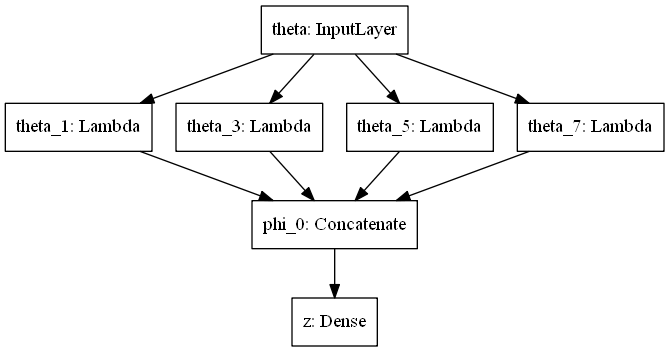

In [20]:
keras.utils.plot_model(model_tan_, show_shapes=False)

In [21]:
model_tan_.summary()

Model: "model_tan_[]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta_1 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_3 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_5 (Lambda)                (None, 1)            0           theta[0][0]                      
_______________________________________________________________________________________

In [22]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_tan_.load_weights('../models/polar/model_tan_[].h5')
    model_tan_.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_tan_ = vartbl['hist_tan_']
    print('Loaded model_tan_.')
except:
    hist = compile_and_fit(model=model_tan_, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_tan_ = hist.history
    vartbl['hist_tan_'] = hist_tan_
    save_vartbl(vartbl, fname)

Epoch 0001; loss 3.61e+04; elapsed 0:00:01
Epoch 0100; loss 3.61e+04; elapsed 0:00:11
Epoch 0200; loss 3.60e+04; elapsed 0:00:22
Epoch 0300; loss 3.60e+04; elapsed 0:00:32
Epoch 0400; loss 3.60e+04; elapsed 0:00:42


KeyboardInterrupt: 

In [ ]:
model_tan_.evaluate(ds_p2c)

In [ ]:
fig, ax = plot_loss_hist(hist_tan_, 'tan: []')

In [ ]:
fig, ax = plot_pred_tan(model_tan_, theta)

In [ ]:
fig, ax = plot_error_tan(model_tan_, theta)

### Network Design 1: [64]
(model_tan_64 has one layer with 64 hidden units)

In [ ]:
# Build the NN model of z=tan(theta)
model_tan_64 = make_model_pow(func_name='tan', 
                              input_name='theta',
                              output_name='z',
                              powers=[1,3,5,7],
                              skip_layers=True,
                              hidden_sizes=[64])

In [ ]:
keras.utils.plot_model(model_tan_64, show_shapes=False)

In [ ]:
model_tan_64.summary()

**Load the network and its loss history if available; otherwise train it**

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_tan_64.load_weights('../models/polar/model_tan_[64].h5')
    model_tan_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_tan_64 = vartbl['hist_tan_64']
    print('Loaded model_tan_64.')
except:
    hist = compile_and_fit(model=model_tan_64, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_tan_64 = hist.history
    vartbl['hist_tan_64'] = hist_tan_64
    save_vartbl(vartbl, fname)

In [ ]:
model_tan_64.evaluate(ds_p2c)

In [ ]:
fig, ax = plot_loss_hist(hist_tan_64, 'tan: [64]')

In [ ]:
fig, ax = plot_pred_tan(model_tan_64, theta)

In [ ]:
fig, ax = plot_error_tan(model_tan_64, theta)

### Network Design 2: [16, 16]
(model_tan_16_16 has two layers with 16 hidden units each)

In [ ]:
model_tan_16_16 = make_model_pow(func_name='tan', 
                              input_name='theta',
                              output_name='z',
                              powers=[1,3,5,7],
                              skip_layers=True,
                              hidden_sizes=[16, 16])

In [ ]:
keras.utils.plot_model(model_tan_16_16)

In [ ]:
model_tan_16_16.summary()

**Load the network and its loss history if available; otherwise train it**

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_tan_16_16.load_weights('../models/polar/model_tan_[16, 16].h5')
    model_tan_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_tan_16_16 = vartbl['hist_tan_16_16']
    print('Loaded model_tan_16_16.')
except:
    hist = compile_and_fit(model=model_tan_16_16, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_tan_16_16 = hist.history
    vartbl['hist_tan_16_16'] = hist_tan_16_16
    save_vartbl(vartbl, fname)

In [ ]:
model_tan_16_16.evaluate(ds_p2c)

In [ ]:
fig, ax = plot_loss_hist(hist_tan_16_16, 'tan: [16, 16]')

In [ ]:
fig, ax = plot_pred_tan(model_tan_16_16, theta)

In [ ]:
fig, ax = plot_error_tan(model_tan_16_16, theta)

## Neural networks for $\theta = \arctan(z)$

## Functions for visualizing neural network outputs $\theta = \arctan(z)$

In [ ]:
def plot_pred_arctan(model, z):
    # Predictions of the model
    theta_pred = model.predict(z)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \\arctan(z)$ for {model.name}')
    ax.set_xlabel('$z$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-10.0, 10.0)
    # ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(-np.pi/2.0, np.pi/2.0)
    ax.set_yticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_yticklabels(['-np.pi/2', '-np.pi/4', '0', '$\pi/4$', '$\pi/2$'])
    ax.plot(z, theta, color='blue', label='$\\arctan(z)$', linewidth=4.0)
    ax.plot(z, theta_pred, color='red', label='NN$(z)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [ ]:
def plot_error_arctan(model, z):
    # Predictions of the model
    theta_pred = model.predict(z)
    theta_pred = theta_pred.reshape((-1,))
    error = theta - theta_pred
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error in $\\theta = \\arctan(z)$ for {model.name}')
    ax.set_xlabel('$z$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-10.0, 10.0)
    # ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(z, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

### Network Design 1: [64]

In [ ]:
model_arctan_64 = make_model_pow(func_name='arctan', 
                                 input_name = 'z',
                                 output_name='theta', 
                                 powers=[1,3,5,7],
                                 skip_layers=True,                                    
                                 hidden_sizes=[64])

In [ ]:
keras.utils.plot_model(model_arctan_64)

In [ ]:
model_arctan_64.summary()

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arctan_64.load_weights('../models/polar/model_arctan_[64].h5')
    model_arctan_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arctan_64 = vartbl['hist_arctan_64']
    print('Loaded model_arctan_64.')
except:
    hist = compile_and_fit(model=model_arctan_64, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arctan_64 = hist.history
    vartbl['hist_arctan_64'] = hist_arctan_64
    save_vartbl(vartbl, fname)

In [ ]:
model_arctan_64.evaluate(ds_c2p)

In [ ]:
fig, ax = plot_loss_hist(hist_arctan_64, 'arctan: [64]')

In [ ]:
fig, ax = plot_pred_arctan(model_arctan_64, x)

In [ ]:
fig, ax = plot_error_arctan(model_arctan_64, x)

### Network Design 2: [16, 16]

In [ ]:
model_arctan_16_16 = make_model_pow(func_name='arctan', 
                                    input_name = 'x',
                                    output_name='theta',
                                    powers=[1,3,5,7],
                                    skip_layers=True,                                    
                                    hidden_sizes=[16, 16])

In [ ]:
keras.utils.plot_model(model_arctan_16_16)

In [ ]:
model_arctan_16_16.summary()

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arctan_16_16.load_weights('../models/polar/model_arctan_[16, 16].h5')
    model_arctan_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arctan_16_16 = vartbl['hist_arctan_16_16']
    print('Loaded model_arctan_16_16.')
except:
    hist = compile_and_fit(model=model_arctan_16_16, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arctan_16_16 = hist.history
    vartbl['hist_arctan_16_16'] = hist_arctan_16_16
    save_vartbl(vartbl, fname)

In [ ]:
model_arctan_16_16.evaluate(ds_c2p)

In [ ]:
fig, ax = plot_loss_hist(hist_arctan_16_16, 'arctan: [16, 16]')

In [ ]:
fig, ax = plot_pred_arctan(model_arctan_16_16, x)

In [ ]:
fig, ax = plot_error_arctan(model_arctan_16_16, x)

In [ ]:
# copies of model instances
model_tan = keras.models.clone_model(model_tan_16_16)
model_tan.set_weights(model_tan_16_16.get_weights())
model_arctan = keras.models.clone_model(model_arctan_16_16)
model_arctan.set_weights(model_arctan_16_16.get_weights())

# remove special characters from model names
# otherwise make_model_autoencoder fails with invalid scope name due to [16, 16] in model names
model_tan._name = 'model_tan'
model_arctan._name = 'model_arctan'

In [ ]:
model_p2p, model_c2c = make_model_autoencoder(
    model_p2c = model_tan,
    model_c2p = model_arctan)

In [ ]:
model_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_p2p.evaluate(ds_p2p)

In [ ]:
model_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_c2c.evaluate(ds_c2c)